In [33]:
import pandas as pd
import jax.numpy as jnp
import evofr as ef

In [34]:
# Getting data
raw_cases = pd.read_csv("../data/monkeypox-cases-counts.tsv", sep="\t")
raw_cases

,location,date,cases
0,Colombia,2022-06-25,3.0
1,Colombia,2022-06-26,0.0
2,Colombia,2022-06-27,0.0
3,Colombia,2022-06-28,0.0
4,Colombia,2022-06-29,0.0
...,...,...,...
1294,World,2022-10-26,657.0
1295,World,2022-10-27,102.0
1296,World,2022-10-28,244.0
1297,World,2022-10-29,143.0


In [35]:
# Make case_data dictionary
case_data = dict()
for name, group in raw_cases.groupby("location"):
    case_data[name] = ef.CaseCounts(raw_cases=group)

In [101]:
# Defining model
seed_L = 7
forecast_L = 0

# Get delays
#TODO: Get better estimates of generation time from the literature
gen = ef.discretise_gamma(mn=7.1, std=3.2)
delays = ef.pad_delays([ef.discretise_lognorm(mn=4.1, std=1.0)])
    
basis_fn = ef.Spline(order=4, k=3)

renewal_model = ef.SingleRenewalModel(gen, delays, seed_L, forecast_L,
                       CLik = ef.ZINegBinomCases(0.01),
                       basis_fn = basis_fn)

In [102]:
# Fitting model
multiposterior = ef.MultiPosterior()
for name, data in case_data.items():
    print(name)
    init_strat, posterior_map = ef.init_to_MAP(renewal_model, data, iters=100_000)
    inference_method = ef.InferNUTS(num_warmup=200, num_samples=200, init_strategy=init_strat)
    posterior = inference_method.fit(renewal_model, data, name=name)
    multiposterior.add_posterior(posterior)

Colombia


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:10<00:00, 37.42it/s, 1023 steps of size 4.16e-04. acc. prob=0.83]


France


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 31.80it/s, 1023 steps of size 2.70e-04. acc. prob=0.91]


Germany


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 34.86it/s, 1023 steps of size 7.11e-04. acc. prob=0.80]


Portugal


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:14<00:00, 28.33it/s, 1023 steps of size 9.07e-06. acc. prob=0.87]


Spain


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 30.80it/s, 1023 steps of size 9.34e-04. acc. prob=0.77]


United Kingdom


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:13<00:00, 28.90it/s, 1023 steps of size 7.81e-04. acc. prob=0.73]


United States


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 35.33it/s, 1023 steps of size 6.15e-04. acc. prob=0.80]


World


sample: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 35.23it/s, 1023 steps of size 1.95e-03. acc. prob=0.95]


In [103]:
# Need to make export methods for R and incidence
# Maybe some quick plots

In [138]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 16}

matplotlib.rc('font', **font)

In [139]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]

v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

In [148]:
from evofr.plotting import *

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [141]:
def plot_site(ax, site, samples, ps, alphas, color):
    med, V = get_quantiles(samples, ps, site)
    t = jnp.arange(0, V[-1].shape[-1], 1)

    # Make figure
    for i in range(len(ps)):
        ax.fill_between(
            t, V[i][0, :], V[i][1, :], color=color, alpha=alphas[i]
        )
    ax.plot(t, med, color=color)

In [142]:
def plot_posterior_Reff_r(posterior, color="grey"):
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1)

    # Plot Reff
    ax = fig.add_subplot(gs[0,0])
    plot_site(ax, "R", posterior.samples, ps, alphas, color)
    ax.set_ylabel("Effective Reproduction number") # Making ylabel

    # Plot little R
    ax = fig.add_subplot(gs[1,0], sharex=ax)
    plot_site(ax, "r", posterior.samples, ps, alphas, color)
    ax.set_ylabel("Epidemic growth rate (per day)") # Making ylabel

    # Add dates
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates

    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return None

In [143]:
def plot_posterior_Ismooth_cases(posterior, color="grey"):
    fig = plt.figure(figsize=(14, 7))
    gs = fig.add_gridspec(nrows=1, ncols=1)

    # Plot smoothed incidence
    ax = fig.add_subplot(gs[0,0])
    plot_site(ax, "I_smooth", posterior.samples, ps, alphas, color)

    plot_cases(ax, posterior.data)
    ax.set_ylabel("Cases") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates
    return None

In [163]:
def plot_cute_posterior(posterior, main_color="#FF00FF", title=""):
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[0.7, 0.3])

    # Plot smoothed incidence and cases
    ax = fig.add_subplot(gs[0,0])
    simple_axis(ax)
    plot_site(ax, "I_smooth", posterior.samples, ps, alphas, main_color)
    plot_cases(ax, posterior.data)
    ax.set_ylabel("Cases") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates
    ax.set_title(title)
    
    # Plot Reff
    ax = fig.add_subplot(gs[1,0])
    simple_axis(ax)
    plot_site(ax, "R", posterior.samples, ps, alphas, main_color)
    ax.set_ylabel(r"$R_{t}$") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=14) # Adding dates
    ax.axhline(y=1.0, color="k", linestyle="--")
    return None

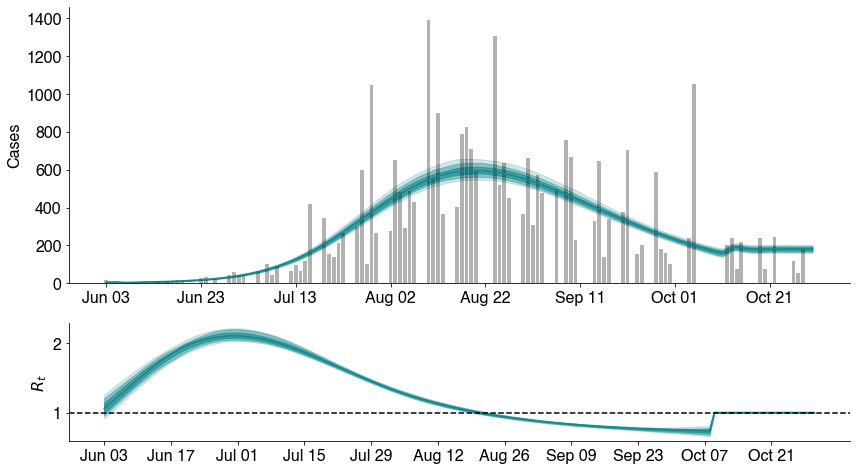

In [164]:
posterior = multiposterior["United States"]
plot_cute_posterior(posterior, main_color="#14888c")

In [165]:
def get_site(
    samples, data, ps, name, site, forecast=False
):

    dates = data.dates

    # Unpack posterior
    site_name = site + "_forecast" if forecast else site
    site = samples[site_name]
    T = site.shape[-1]

    if forecast:
        dates = forecast_dates(dates, T)

    # Compute medians and hdis for ps
    site_median = jnp.median(site, axis=0)

    site_hdis = [
        jnp.quantile(site, q=jnp.array([0.5 * (1 - p), 0.5 * (1 + p)]), axis=0)
        for p in ps
    ]

    site_dict = dict()
    site_dict["date"] = list(dates)
    site_dict["location"] = [name] * T
    site_dict[f"median_{site_name}"] = list(site_median)
    for i, p in enumerate(ps):
        site_dict[f"{site_name}_upper_{round(ps[i] * 100)}"] = list(site_hdis[i][1, :])
        site_dict[f"{site_name}_lower_{round(ps[i] * 100)}"] = list(site_hdis[i][0, :])        
    return site_dict

In [166]:
def site_posteriors_to_dataframe(mp, site, ps):
    dfs = []
    for name, post in multiposterior.locator.items():
        site_dict_name = get_site(post.samples, post.data, ps, name, site, forecast=False)
        dfs.append(
            pd.DataFrame(site_dict_name)
        )
    return pd.concat(dfs)

In [167]:
Rt_estimates = site_posteriors_to_dataframe(multiposterior, "R", [0.8])

In [168]:
incidence_estimates = site_posteriors_to_dataframe(multiposterior, "I_smooth", [0.8])

In [169]:
Rt_estimates.to_csv("case-rt-estimates.tsv", index=False, sep="\t")
incidence_estimates.to_csv("case-incidence-estimates.tsv", index=False, sep="\t")